## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [6]:
DATASET = "compas_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 1
ATTACK = "mia1"

In [7]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [8]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [9]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [10]:
dataset_orig.features.shape

(6172, 10)

In [11]:
privileged_groups

[{'sex': 1}]

In [12]:
sens_attr

'sex'

In [13]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [14]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[  0.  22.   2. ...   0.   0.  79.]
 [  0.  39.   0. ...   2.   0. 143.]
 [  1.  21.   2. ...   0.   0.  54.]
 ...
 [  0.  21.   2. ...   1.   1.  26.]
 [  0.  43.   0. ...   5.   1. 388.]
 [  1.  24.   2. ...   3.   1. 215.]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [15]:
seed = 1234
np.random.seed(seed)

In [16]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [17]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [18]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [19]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [20]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [21]:
df, _ = dataset_orig.convert_to_dataframe()

In [22]:
df[['sex','two_year_recid']].value_counts()

sex  two_year_recid
0.0  0.0               2601
     1.0               2396
1.0  0.0                762
     1.0                413
Name: count, dtype: int64

In [23]:
# target_dataset = None
# reference_dataset = None

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [26]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
privileged vs. unprivileged:  580.0 2506.0
base_pos unpriv:  0.47685554668794894
base_pos priv:  0.3603448275862069
DIFFERENCE IS GOOD
base_pos unpriv:  0.47685554668794894
base_pos priv:  0.3603448275862069
no bias type specified
#### Training Dataset shape
(3086, 10)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc']
number of favorable labels:  1404
Difference in mean outcomes between unprivileged and privileged groups = 0.116511
#### Train shape, validation shape, test shape
(3086, 10) (3086, 10) (3086, 10)
#######################################################################
                    dt
##########

TEST
Best thresh:  0.47000000000000003
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.16
  Positive predictive value: 0.63
  Optimal thershold: -1.4213856809311607
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1682, Test = 1681
  AUC: 0.59
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.13
  Positive predictive value: 0.62
  Optimal thershold: -0.4909103140650493
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1404, Test = 1405
  AUC: 0.65
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.22
  Positive predictive value: 0.63
  Optimal thershold: -1.4213856809311607
)
MIA_Result(
  Name: subpopulat

Number of training samples (ntrain): 1289
Number of test samples (ntest): 1312
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1197
Number of test samples (ntest): 1199
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 397
Number of test samples (ntest): 365
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 203
Number of test samples (ntest): 210
TEST
Best thresh:  0.47000000000000003
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -1.041453874828161
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1686, Test = 1677
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0

Best thresh:  0.42000000000000004
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.18
  Positive predictive value: 0.59
  Optimal thershold: -0.5955576345789076
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1686, Test = 1677
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -0.5955576345789076
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1400, Test = 1409
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.22
  Positive predictive value: 0.60
  Optimal thershold: -0.9614050064091378
)
MIA_Result(
  Name: subpopulation

origin, transf:  3086 3086
after transf priv:  0.36505190311418684
after transf unpriv:  0.48444976076555024
Difference in mean outcomes between unprivileged and privileged groups = 0.119398
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1293
Number of test samples (ntest): 1308
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1215
Number of test samples (ntest): 1181
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 367
Number of test samples (ntest): 395
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 211
Number of test samples (ntest): 202
TEST
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.15
  Positive predictive value: 0.61
  Optima

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1293
Number of test samples (ntest): 1308
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1215
Number of test samples (ntest): 1181
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 367
Number of test samples (ntest): 395
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 211
Number of test samples (ntest): 202
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.09
  Positive predictive value: 0.64
  Optimal thershold: -0.046261542380612204
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1660, Test = 1703
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.20
  Attacker

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1310
Number of test samples (ntest): 1291
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1197
Number of test samples (ntest): 1199
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 369
Number of test samples (ntest): 393
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 210
Number of test samples (ntest): 203
TEST
Best thresh:  0.43
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.19
  Positive predictive value: 0.59
  Optimal thershold: -0.6097655716208943
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1679, Test = 1684
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.49
  

Number of training samples (ntrain): 1201
Number of test samples (ntest): 1195
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 378
Number of test samples (ntest): 384
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 209
Number of test samples (ntest): 204
TEST
Best thresh:  0.42000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -1.0033021088637848
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1676, Test = 1687
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.12
  Positive predictive value: 0.57
  Optimal thershold: -0.7985076962177717
)
MIA_Result(
  Name: entire_datas

Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -0.9713953039580789
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1676, Test = 1687
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.13
  Positive predictive value: 0.57
  Optimal thershold: -0.9202282299711739
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1410, Test = 1399
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.21
  Positive predictive value: 0.63
  Optimal thershold: -1.0170975214284457
)
MIA_Result(
  Name: subpopulation

origin, transf:  3086 3086
after transf priv:  0.33884297520661155
after transf unpriv:  0.48327287384119305
Difference in mean outcomes between unprivileged and privileged groups = 0.144430
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1282
Number of test samples (ntest): 1319
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1199
Number of test samples (ntest): 1197
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 400
Number of test samples (ntest): 362
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 205
Number of test samples (ntest): 208
TEST
Best thresh:  0.38
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.19
  Positive predictive value: 0.60
  Optim

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1282
Number of test samples (ntest): 1319
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1199
Number of test samples (ntest): 1197
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 400
Number of test samples (ntest): 362
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 205
Number of test samples (ntest): 208
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.59
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.13
  Positive predictive value: 0.60
  Optimal thershold: -0.0581573219459079
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1682, Test = 1681
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.50
  Attacker a

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1316
Number of test samples (ntest): 1285
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1177
Number of test samples (ntest): 1219
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 391
Number of test samples (ntest): 371
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 202
Number of test samples (ntest): 211
TEST
Best thresh:  0.46
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.17
  Positive predictive value: 0.57
  Optimal thershold: -1.0704414117014134
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1707, Test = 1656
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.82
  Test Accuracy

Number of training samples (ntrain): 1228
Number of test samples (ntest): 1168
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 364
Number of test samples (ntest): 398
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 208
Number of test samples (ntest): 205
TEST
Best thresh:  0.5
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.14
  Positive predictive value: 0.60
  Optimal thershold: -0.916290731874155
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1650, Test = 1713
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.13
  Positive predictive value: 0.61
  Optimal thershold: -0.7859289140109115
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Si

Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 364
Number of test samples (ntest): 398
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 208
Number of test samples (ntest): 205
TEST
Best thresh:  0.41000000000000003
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.15
  Positive predictive value: 0.59
  Optimal thershold: -0.9071765018488749
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1650, Test = 1713
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.14
  Positive predictive value: 0.59
  Optimal thershold: -1.1428471012811214
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1436, Test = 1373
  AUC: 0.61
  P


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  3086 3086
after transf priv:  0.358843537414966
after transf unpriv:  0.48078462770216174
Difference in mean outcomes between unprivileged and privileged groups = 0.121941
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1297
Number of test samples (ntest): 1304
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1201
Number of test samples (ntest): 1195
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 377
Number of test samples (ntest): 385
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 211
Number of test samples (ntest): 202
TEST
Best thresh:  0.44
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.8

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1297
Number of test samples (ntest): 1304
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1201
Number of test samples (ntest): 1195
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 377
Number of test samples (ntest): 385
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 211
Number of test samples (ntest): 202
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.13
  Positive predictive value: 0.59
  Optimal thershold: -0.05506567879673196
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1674, Test = 1689
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.35
  Attacker 

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1266
Number of test samples (ntest): 1335
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1220
Number of test samples (ntest): 1176
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 391
Number of test samples (ntest): 371
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 209
Number of test samples (ntest): 204
TEST
Best thresh:  0.47000000000000003
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.15
  Positive predictive value: 0.60
  Optimal thershold: -0.8602012652231115
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1657, Test = 1706
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.70


Number of training samples (ntrain): 1218
Number of test samples (ntest): 1178
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 368
Number of test samples (ntest): 394
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 217
Number of test samples (ntest): 196
TEST
Best thresh:  0.49
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -0.8023464725249373
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1651, Test = 1712
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.16
  Positive predictive value: 0.60
  Optimal thershold: -0.8023464725249373
)
MIA_Result(
  Name: entire_dataset_label_1.0
  

Best thresh:  0.46
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: -0.9363695714991795
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1651, Test = 1712
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: -0.7221185925045648
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1435, Test = 1374
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -1.1958553493958732
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0


RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1311
Number of test samples (ntest): 1290
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1214
Number of test samples (ntest): 1182
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 357
Number of test samples (ntest): 405
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 204
Number of test samples (ntest): 209
TEST
Best thresh:  0.42000000000000004
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.18
  Positive predictive value: 0.59
  Optimal thershold: -0.9903987040278769
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1668, Test = 1695
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.9

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1311
Number of test samples (ntest): 1290
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1214
Number of test samples (ntest): 1182
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 357
Number of test samples (ntest): 405
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 204
Number of test samples (ntest): 209
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.12
  Positive predictive value: 0.63
  Optimal thershold: -0.050241233988683215
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1668, Test = 1695
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.36
  Attacker

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1287
Number of test samples (ntest): 1314
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1203
Number of test samples (ntest): 1193
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 394
Number of test samples (ntest): 368
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 202
Number of test samples (ntest): 211
TEST
Best thresh:  0.5
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.20
  Positive predictive value: 0.57
  Optimal thershold: -1.0704414117014134
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1681, Test = 1682
  AUC: 0.63
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.85
  Test Accuracy 

Number of training samples (ntrain): 1185
Number of test samples (ntest): 1211
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 391
Number of test samples (ntest): 371
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 207
Number of test samples (ntest): 206
TEST
Best thresh:  0.48000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.14
  Positive predictive value: 0.61
  Optimal thershold: -0.8754687373538999
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1694, Test = 1669
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.14
  Positive predictive value: 0.60
  Optimal thershold: -0.5172565140962812
)
MIA_Result(
  Name: entire_datas

Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.14
  Positive predictive value: 0.59
  Optimal thershold: -0.8432572305719919
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1694, Test = 1669
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.14
  Positive predictive value: 0.60
  Optimal thershold: -0.5479999490544001
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1392, Test = 1417
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -0.9697437737300746
)
MIA_Result(
  Name: subpopulation

Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -1.0296194171811583
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1678, Test = 1685
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: -0.46430560813109784
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1408, Test = 1401
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.18
  Positive predictive value: 0.61
  Optimal thershold: -1.1451323043030026
)
MIA_Result(
  Name: subpopulatio

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1284
Number of test samples (ntest): 1317
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1212
Number of test samples (ntest): 1184
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 394
Number of test samples (ntest): 368
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 196
Number of test samples (ntest): 217
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.12
  Positive predictive value: 0.57
  Optimal thershold: -0.04898215635792012
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1678, Test = 1685
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.38
  Attacker 

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1300
Number of test samples (ntest): 1301
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1217
Number of test samples (ntest): 1179
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 370
Number of test samples (ntest): 392
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 199
Number of test samples (ntest): 214
TEST
Best thresh:  0.39
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.17
  Positive predictive value: 0.60
  Optimal thershold: -0.8574502318512216
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1670, Test = 1693
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0

Number of training samples (ntrain): 1194
Number of test samples (ntest): 1202
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 381
Number of test samples (ntest): 381
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 230
Number of test samples (ntest): 183
TEST
Best thresh:  0.5
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -0.4054651081081643
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1662, Test = 1701
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: -0.44183275227903934
)
MIA_Result(
  Name: entire_dataset_label_1.0
  

TEST
Best thresh:  0.38
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.16
  Positive predictive value: 0.58
  Optimal thershold: -0.7255648651853338
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1662, Test = 1701
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: -0.5389057722282057
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1424, Test = 1385
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.20
  Positive predictive value: 0.60
  Optimal thershold: -0.7888369373236137
)
MIA_Result(
  Name: subpopulation_0.0_label

origin, transf:  3086 3086
after transf priv:  0.31727574750830567
after transf unpriv:  0.49355877616747185
Difference in mean outcomes between unprivileged and privileged groups = 0.176283
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1258
Number of test samples (ntest): 1343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1226
Number of test samples (ntest): 1170
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 351
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 191
Number of test samples (ntest): 222
TEST
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.17
  Positive predictive value: 0.61
  Optima

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1258
Number of test samples (ntest): 1343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1226
Number of test samples (ntest): 1170
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 351
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 191
Number of test samples (ntest): 222
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.12
  Positive predictive value: 0.57
  Optimal thershold: -0.08265938746200432
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1669, Test = 1694
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.42
  Attacker 

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 1298
Number of test samples (ntest): 1303
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1192
Number of test samples (ntest): 1204
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 387
Number of test samples (ntest): 375
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 209
Number of test samples (ntest): 204
TEST
Best thresh:  0.44
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.17
  Positive predictive value: 0.56
  Optimal thershold: -0.7808527609790509
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1685, Test = 1678
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.36
  

Number of training samples (ntrain): 1181
Number of test samples (ntest): 1215
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 367
Number of test samples (ntest): 395
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 215
Number of test samples (ntest): 198
TEST
Best thresh:  0.34
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.17
  Positive predictive value: 0.61
  Optimal thershold: -0.5306282510621704
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1690, Test = 1673
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.14
  Positive predictive value: 0.61
  Optimal thershold: -0.5306282510621704
)
MIA_Result(
  Name: entire_dataset_label_1.0
  

TEST
Best thresh:  0.42000000000000004
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.16
  Positive predictive value: 0.61
  Optimal thershold: -0.39481491728102047
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 1690, Test = 1673
  AUC: 0.61
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.15
  Positive predictive value: 0.61
  Optimal thershold: -0.3802688673564525
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1396, Test = 1413
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.19
  Positive predictive value: 0.62
  Optimal thershold: -0.732687857626476
)
MIA_Result(
  Name: subpopul

## Display Output

In [27]:
priv_metric_orig_copy = priv_metric_orig

In [28]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 11772.0, 'total_unpriv': 49948.0})

In [29]:
priv_metric_orig

defaultdict(float, {'total_priv': 11772.0, 'total_unpriv': 49948.0})

In [30]:
priv_metric_orig.items()

dict_items([('total_priv', 11772.0), ('total_unpriv', 49948.0)])

In [31]:
priv_metric_orig = priv_metric_orig_copy

In [32]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

compas_sex
3086
2)

              total_priv  total_unpriv
num_instance                          
orig               588.6        2497.4
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig         0.45721        0.54279    0.352408      0.647592      0.481945   
transf       0.45721        0.54279    0.352408      0.647592      0.481945   

         unpriv_unfavor  
dataset                  
orig           0.518055  
transf         0.518055  


# Train/Test Accuracies

In [33]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [34]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [35]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [36]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [37]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./mia1_results/mia1_compas_sex_train_test_accuracies_2024-12-31.csv'

In [38]:
train_test_df

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.831440         0.831202          0.843073   
accuracy_train_0_+       0.729555         0.729417          0.714829   
accuracy_train_1_-       0.918211         0.918443          0.872059   
accuracy_train_1_+       0.680953         0.681389          0.766352   
accuracy_test_0_-        0.687425         0.688296          0.699408   
accuracy_test_0_+        0.575396         0.576865          0.557056   
accuracy_test_1_-        0.785147         0.783392          0.742058   
accuracy_test_1_+        0.430417         0.430682          0.486310   
accuracy_train           0.792417         0.792336          0.791559   
accuracy_test            0.638869         0.639582          0.635353   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.822026     0.788630  
accuracy_train_0_+      0.717216     0.679480  
accuracy_train_1_-      0.929050     0.791097  
accuracy_train_1_+      0.713358     0.679241  
accuracy_test_0_-       0.686873     0.693028  
accuracy_test_0_+       0.565952     0.579755  
accuracy_test_1_-       0.756426     0.711909  
accuracy_test_1_+       0.465006     0.527585  
accuracy_train          0.787119     0.738367  
accuracy_test           0.633717     0.640975

In [39]:
train_test_df.head()

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.831440         0.831202          0.843073   
accuracy_train_0_+       0.729555         0.729417          0.714829   
accuracy_train_1_-       0.918211         0.918443          0.872059   
accuracy_train_1_+       0.680953         0.681389          0.766352   
accuracy_test_0_-        0.687425         0.688296          0.699408   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.822026     0.788630  
accuracy_train_0_+      0.717216     0.679480  
accuracy_train_1_-      0.929050     0.791097  
accuracy_train_1_+      0.713358     0.679241  
accuracy_test_0_-       0.686873     0.693028

In [40]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

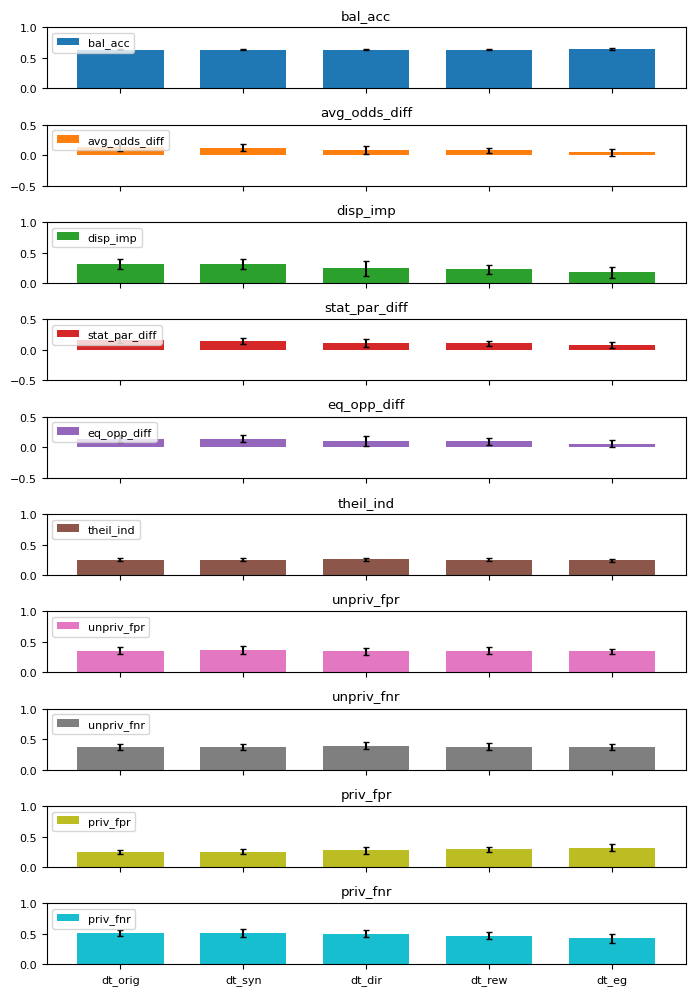

In [41]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [42]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_compas_sex_fairness_metrics_2024-12-31.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [43]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [44]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                           0.581497   
syn                                            0.581424   
dir                                            0.585248   
rew                                            0.581538   
eg                                             0.555873   

                        entire_dataset_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.577200   
syn                                                      0.577199   
dir                                                      0.580209   
rew                                                      0.574932   
eg                                                       0.553347   

                        entire_dataset_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.593054   
syn                                                      0.592961   
dir                                                      0.600674   
rew                                                      0.594494   
eg                                                       0.566627   

                        subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.578679   
syn                                                         0.578313   
dir                                                         0.577807   
rew                                                         0.576655   
eg                                                          0.556195   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.585368   
syn                                                         0.585308   
dir                                                         0.593782   
rew                                                         0.586402   
eg                                                          0.562717   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.582899   
syn                                                         0.583658   
dir                                                         0.602665   
rew                                                         0.578388   
eg                                                          0.557714   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.647938  
syn                                                         0.647701  
dir                                                         0.655163  
rew                                                         0.653541  
eg                                                          0.601999

In [45]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [46]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [47]:
df_groups

subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.578679   
syn                                                         0.578313   
dir                                                         0.577807   
rew                                                         0.576655   
eg                                                          0.556195   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.582899   
syn                                                         0.583658   
dir                                                         0.602665   
rew                                                         0.578388   
eg                                                          0.557714   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.585368   
syn                                                         0.585308   
dir                                                         0.593782   
rew                                                         0.586402   
eg                                                          0.562717   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.647938  
syn                                                         0.647701  
dir                                                         0.655163  
rew                                                         0.653541  
eg                                                          0.601999

<Axes: xlabel='Classifier MIA Attacks'>

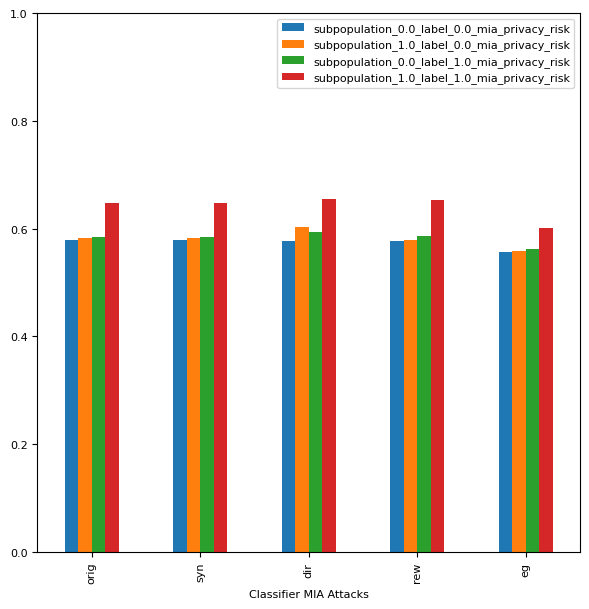

In [48]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [49]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.578679  0.578313  0.577807  0.576655  0.556195
subpopulation_1.0_label_0.0_mia_privacy_risk  0.582899  0.583658  0.602665  0.578388  0.557714
subpopulation_0.0_label_1.0_mia_privacy_risk  0.585368  0.585308  0.593782  0.586402  0.562717
subpopulation_1.0_label_1.0_mia_privacy_risk  0.647938  0.647701  0.655163  0.653541  0.601999


## Save Results

In [50]:
errors

[{'entire_dataset_mia_privacy_risk': 0.006046563452145823,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.008684293425017328,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.008117404468724642,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.007754676010126451,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.009540742777187361,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.014139857301276777,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.02665728744831914},
 {'entire_dataset_mia_privacy_risk': 0.006492484368983507,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.00868353056254415,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.00916729154576409,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.0078081234537914525,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.01053473676540756,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.014495826769495488,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.027753295928572036},
 {'entire_dataset_mia_privacy_r

In [51]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_compas_sex_mia_privacy_risks_metrics_2024-12-31.csv


# Main Bar Graph Visualization

In [52]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

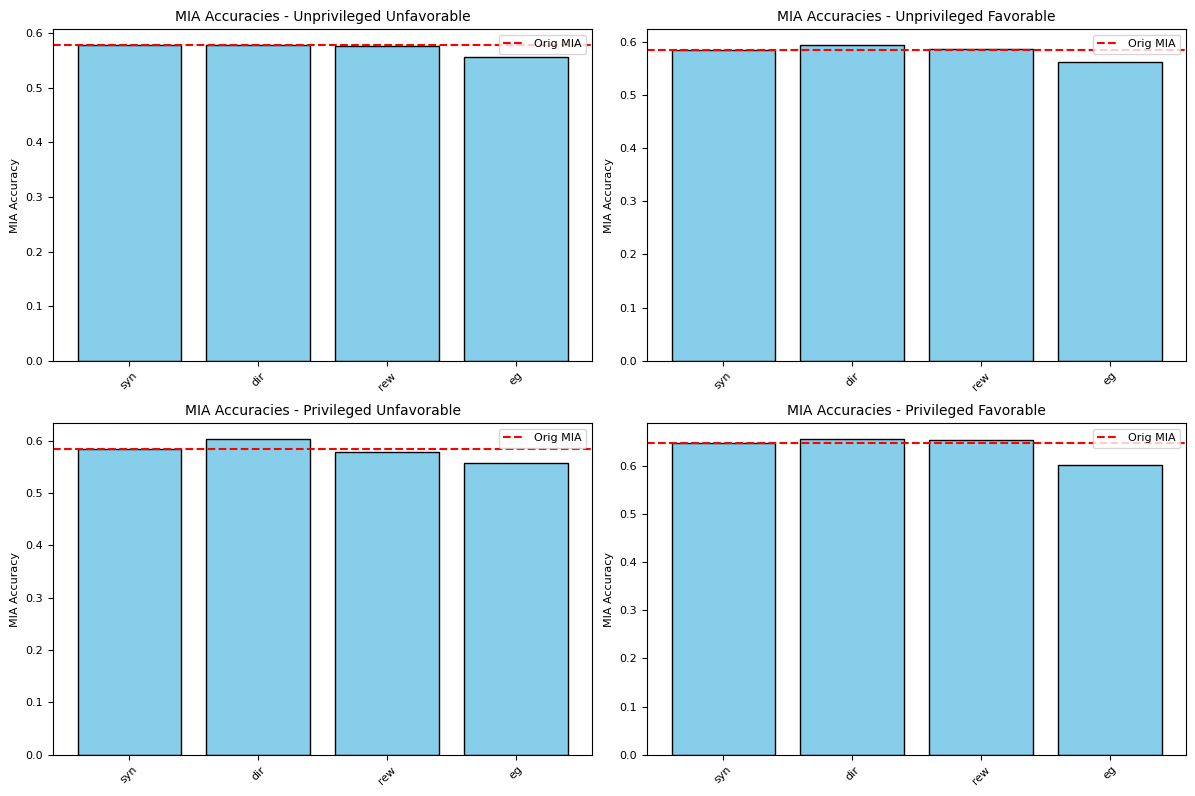

In [53]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [54]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [55]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [56]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.577771
1       orig               entire_dataset_mia_privacy_risk      0.580201
2       orig               entire_dataset_mia_privacy_risk      0.572748
3       orig               entire_dataset_mia_privacy_risk      0.588464
4       orig               entire_dataset_mia_privacy_risk      0.577771
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.595583
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.611701
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.613886
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.595436
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.602478

[700 rows x 3 columns]

In [57]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.577771
1       orig               entire_dataset_mia_privacy_risk      0.580201
2       orig               entire_dataset_mia_privacy_risk      0.572748
3       orig               entire_dataset_mia_privacy_risk      0.588464
4       orig               entire_dataset_mia_privacy_risk      0.577771
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.595583
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.611701
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.613886
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.595436
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.602478

[500 rows x 3 columns]

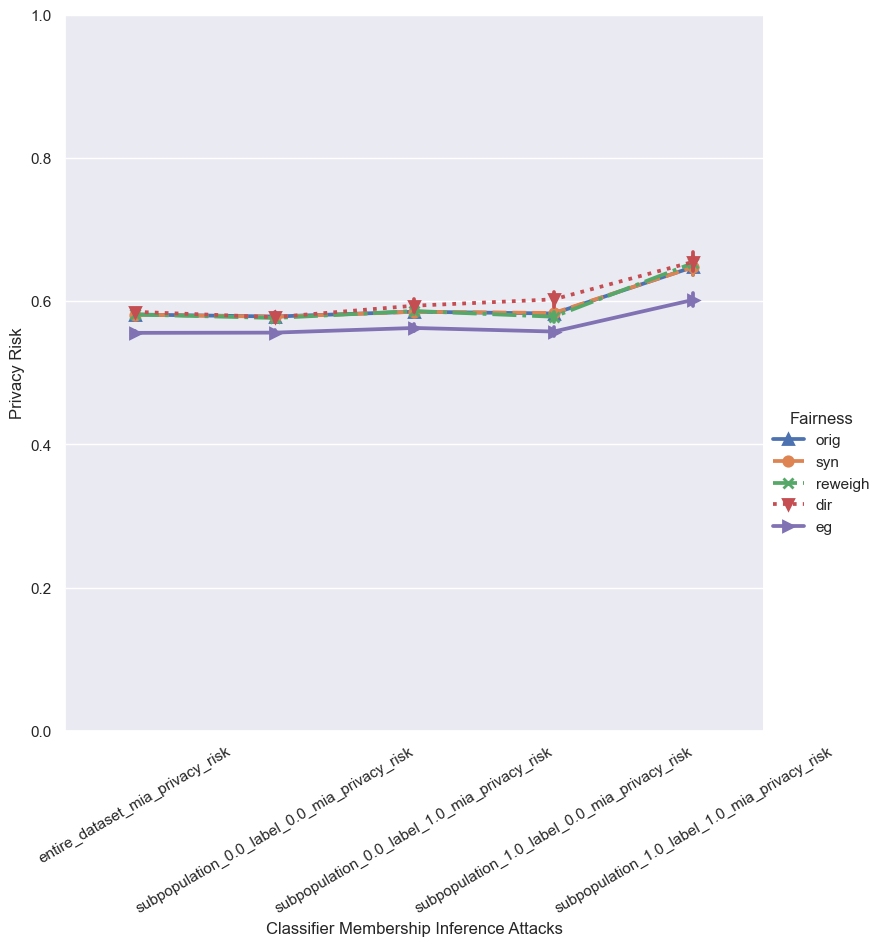

In [58]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [59]:
from sklearn.metrics import RocCurveDisplay, auc

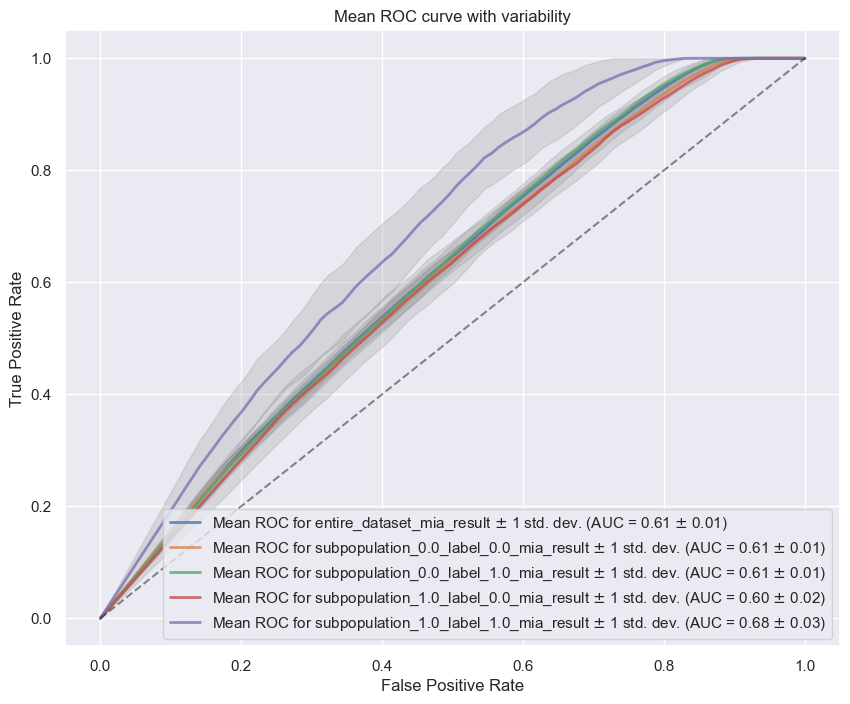

In [60]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.16
  Positive predictive value: 0.61
  Optimal thershold: -0.3829922522561057
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: -1.041453874828161
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.15
  Positive predictive value: 0.60
  Optimal thershold: -0.48550781578170077
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3086, Test = 3086
  AUC: 0.62
  Privacy Risk: 0.5

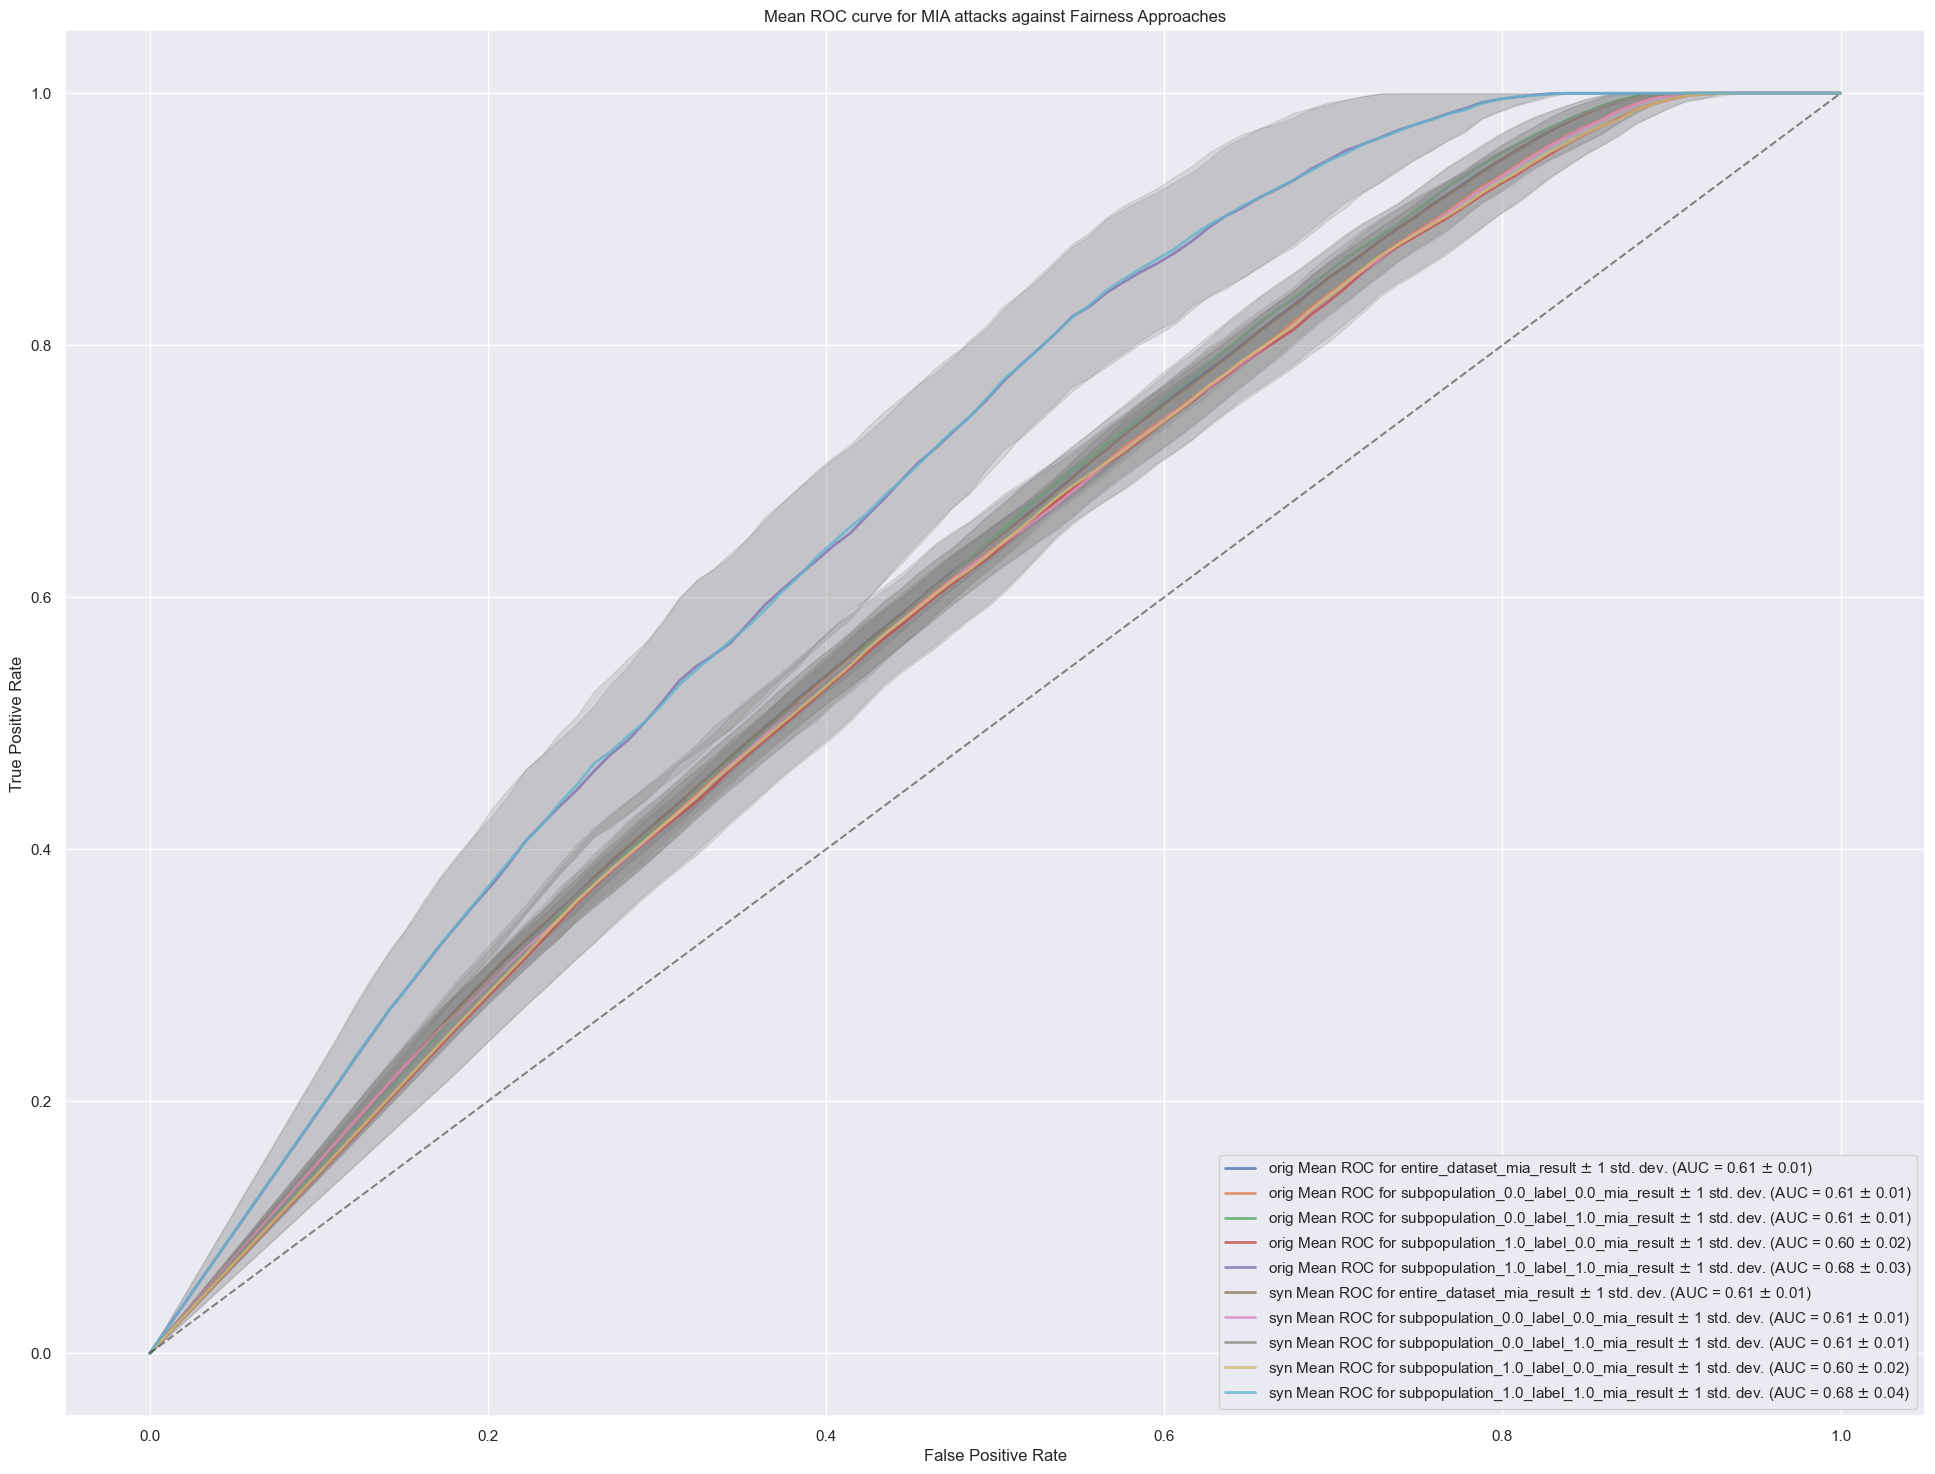

In [61]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

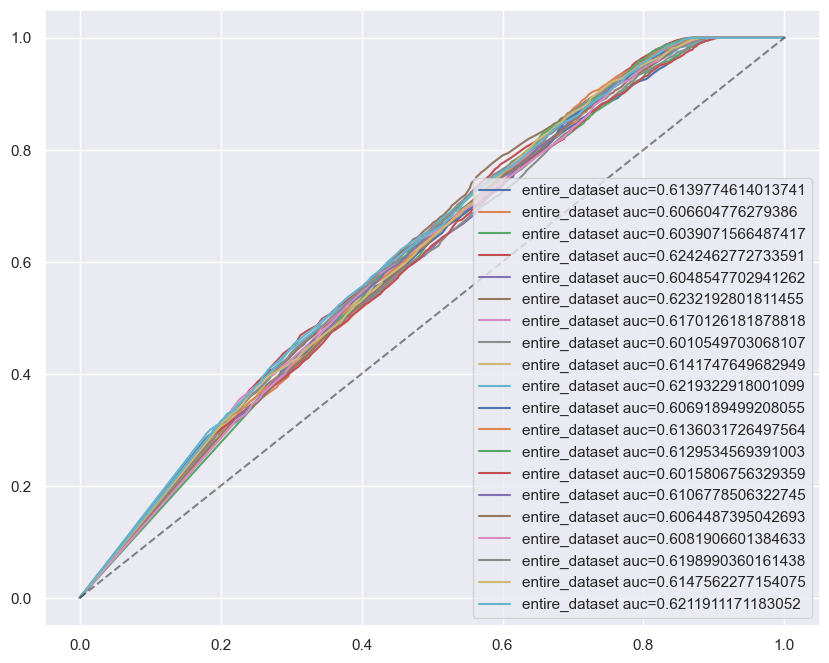

In [62]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [63]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [64]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_auc  \
Classifier MIA Attacks                           
orig                                  0.612360   
syn                                   0.612228   
dir                                   0.606048   
rew                                   0.611294   
egr                                   0.572772   

                        entire_dataset_label_0.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.604988   
syn                                             0.604775   
dir                                             0.597708   
rew                                             0.601755   
egr                                             0.568062   

                        entire_dataset_label_1.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.622971   
syn                                             0.622912   
dir                                             0.617422   
rew                                             0.624269   
egr                                             0.581511   

                        subpopulation_0.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.606535   
syn                                                0.605775   
dir                                                0.590120   
rew                                                0.602697   
egr                                                0.569244   

                        subpopulation_0.0_label_1.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.612689   
syn                                                0.612522   
dir                                                0.605826   
rew                                                0.612775   
egr                                                0.575767   

                        subpopulation_1.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.601875   
syn                                                0.603316   
dir                                                0.621454   
rew                                                0.599168   
egr                                                0.564055   

                        subpopulation_1.0_label_1.0_mia_auc  
Classifier MIA Attacks                                       
orig                                               0.680529  
syn                                                0.680974  
dir                                                0.677267  
rew                                                0.686085  
egr                                                0.615815

<Axes: xlabel='Classifier MIA Attacks'>

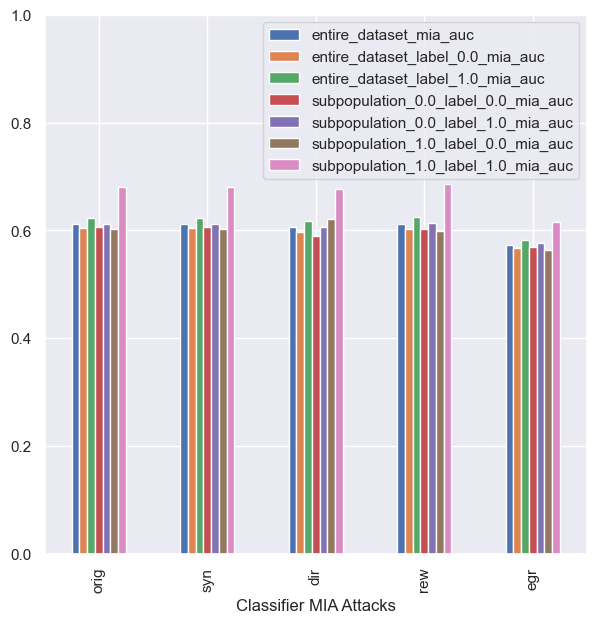

In [65]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [66]:
# Creating data structures to plot point categorical plot from seaborn

In [67]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [68]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.1555411535968892],
 ['orig', 'entire_dataset', 0.16040181464679193],
 ['orig', 'entire_dataset', 0.14549578742709002],
 ['orig', 'entire_dataset', 0.1769280622164614],
 ['orig', 'entire_dataset', 0.15554115359688914],
 ['orig', 'entire_dataset', 0.1905379131561893],
 ['orig', 'entire_dataset', 0.1688269604666235],
 ['orig', 'entire_dataset', 0.14257939079714843],
 ['orig', 'entire_dataset', 0.16688269604666228],
 ['orig', 'entire_dataset', 0.1688269604666235],
 ['orig', 'entire_dataset', 0.1629941672067401],
 ['orig', 'entire_dataset', 0.17660401814646787],
 ['orig', 'entire_dataset', 0.17174335709656507],
 ['orig', 'entire_dataset', 0.14160725858716783],
 ['orig', 'entire_dataset', 0.15748541801685023],
 ['orig', 'entire_dataset', 0.15554115359688925],
 ['orig', 'entire_dataset', 0.15878159429682437],
 ['orig', 'entire_dataset', 0.16947504860661056],
 ['orig', 'entire_dataset', 0.16850291639662995],
 ['orig', 'entire_dataset', 0.16558651976668826],
 ['ori

In [69]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

Fairness                          MIA  attacker_advantage
0       orig               entire_dataset            0.155541
1       orig               entire_dataset            0.160402
2       orig               entire_dataset            0.145496
3       orig               entire_dataset            0.176928
4       orig               entire_dataset            0.155541
..       ...                          ...                 ...
695      egr  subpopulation_1.0_label_1.0            0.191166
696      egr  subpopulation_1.0_label_1.0            0.223402
697      egr  subpopulation_1.0_label_1.0            0.227772
698      egr  subpopulation_1.0_label_1.0            0.190872
699      egr  subpopulation_1.0_label_1.0            0.204957

[700 rows x 3 columns]

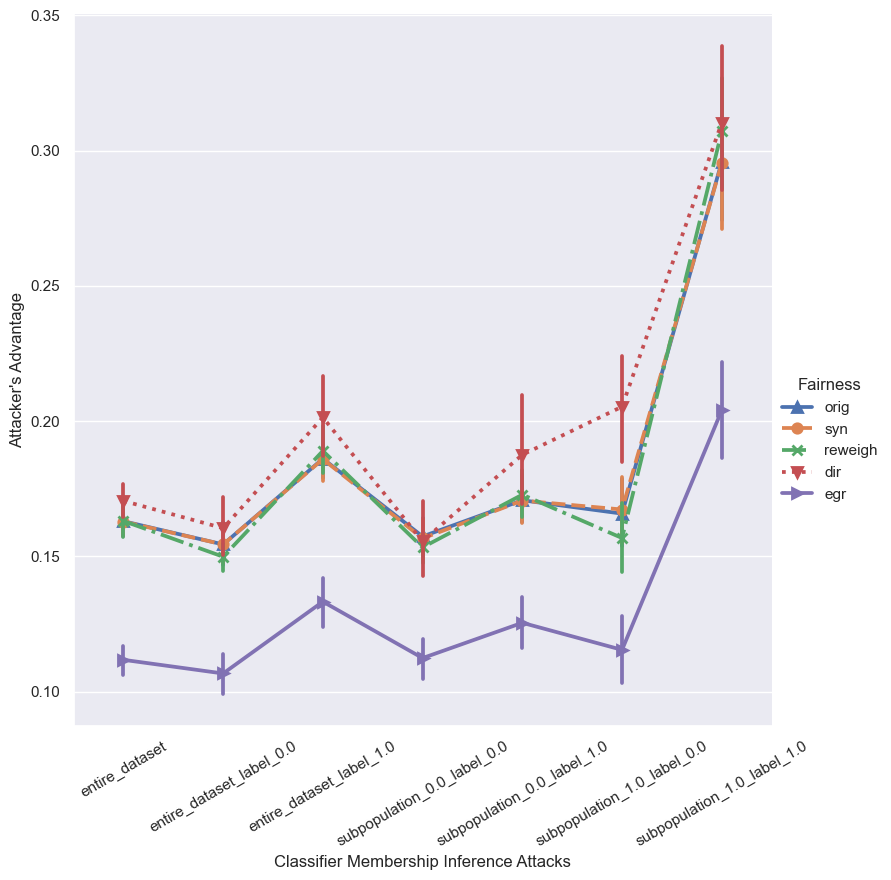

In [70]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


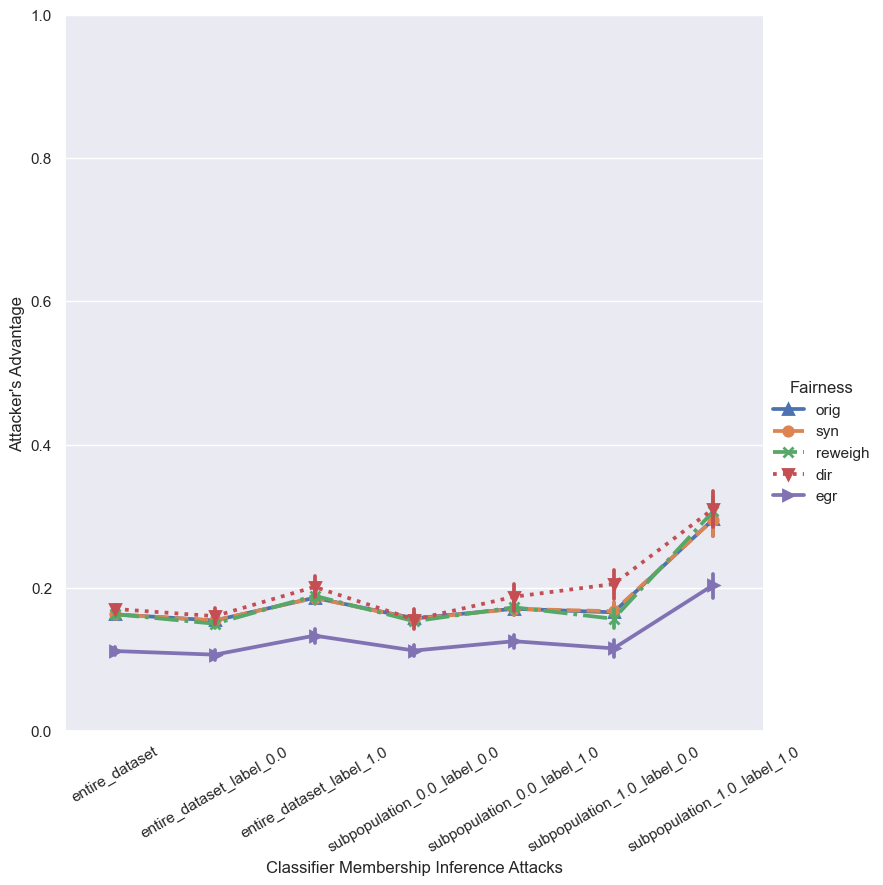

In [71]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [72]:
pd.DataFrame(orig_mia_metrics_att_ad)

entire_dataset_mia_attacker_advantage  \
0                                0.155541   
1                                0.160402   
2                                0.145496   
3                                0.176928   
4                                0.155541   
5                                0.190538   
6                                0.168827   
7                                0.142579   
8                                0.166883   
9                                0.168827   
10                               0.162994   
11                               0.176604   
12                               0.171743   
13                               0.141607   
14                               0.157485   
15                               0.155541   
16                               0.158782   
17                               0.169475   
18                               0.168503   
19                               0.165587   

    entire_dataset_label_0.0_mia_attacker_advantage  \
0                                          0.152401   
1                                          0.149409   
2                                          0.145316   
3                                          0.163851   
4                                          0.119577   
5                                          0.195240   
6                                          0.146958   
7                                          0.134729   
8                                          0.157353   
9                                          0.159224   
10                                         0.155059   
11                                         0.151685   
12                                         0.166288   
13                                         0.139266   
14                                         0.155463   
15                                         0.165260   
16                                         0.147671   
17                                         0.191552   
18                                         0.153172   
19                                         0.138531   

    entire_dataset_label_1.0_mia_attacker_advantage  \
0                                          0.165493   
1                                          0.191155   
2                                          0.165278   
3                                          0.197396   
4                                          0.206860   
5                                          0.186346   
6                                          0.196800   
7                                          0.159794   
8                                          0.193946   
9                                          0.187036   
10                                         0.176599   
11                                         0.209988   
12                                         0.200906   
13                                         0.170070   
14                                         0.180169   
15                                         0.154691   
16                                         0.201384   
17                                         0.183692   
18                                         0.192344   
19                                         0.202203   

    subpopulation_0.0_label_0.0_mia_attacker_advantage  \
0                                            0.154209    
1                                            0.147133    
2                                            0.143383    
3                                            0.167865    
4                                            0.126908    
5                                            0.195949    
6                                            0.144851    
7                                            0.138457    
8                                            0.157824    
9                                            0.169157    
10                                           0.147544    
11                                           0.161

In [73]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [74]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_attacker_advantage  \
Classifier MIA Attacks                                          
orig                                                 0.162994   
syn                                                  0.162848   
dir                                                  0.170496   
rew                                                  0.163075   
egr                                                  0.111747   

                        entire_dataset_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                    
orig                                                           0.154400   
syn                                                            0.154398   
dir                                                            0.160417   
rew                                                            0.149864   
egr                                                            0.106694   

                        entire_dataset_label_1.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                    
orig                                                           0.186108   
syn                                                            0.185922   
dir                                                            0.201347   
rew                                                            0.188989   
egr                                                            0.133255   

                        subpopulation_0.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.157357    
syn                                                              0.156625    
dir                                                              0.155614    
rew                                                              0.153311    
egr                                                              0.112390    

                        subpopulation_0.0_label_1.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.170736    
syn                                                              0.170616    
dir                                                              0.187565    
rew                                                              0.172804    
egr                                                              0.125434    

                        subpopulation_1.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.165799    
syn                                                              0.167317    
dir                                                              0.205330    
rew                                                              0.156776    
egr                                                              0.115427    

                        subpopulation_1.0_label_1.0_mia_attacker_advantage  
Classifier MIA Attacks                                                      
orig                                                             0.295876   
syn                                                              0.295402   
dir                                                              0.310327   
rew                                                              0.307081   
egr                                                              0.203998

<Axes: xlabel='Classifier MIA Attacks'>

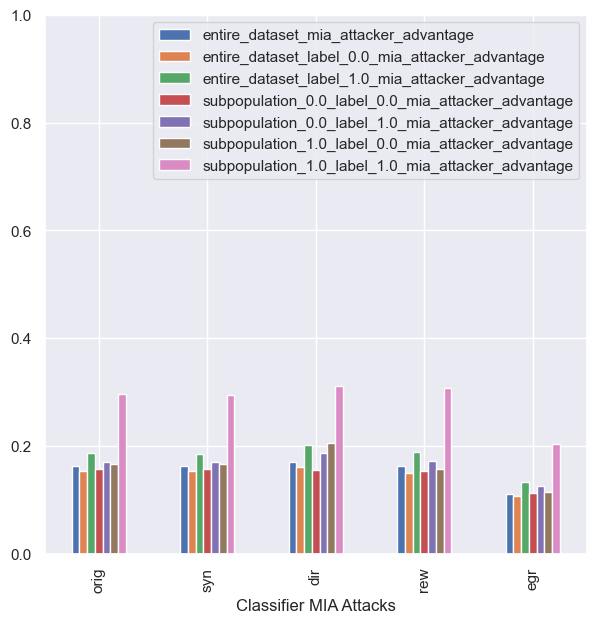

In [75]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [76]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [77]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.6142454160789845],
 ['orig', 'entire_dataset', 0.5879120879120879],
 ['orig', 'entire_dataset', 0.6024355300859598],
 ['orig', 'entire_dataset', 0.6063660477453581],
 ['orig', 'entire_dataset', 0.5901538461538461],
 ['orig', 'entire_dataset', 0.6047804335742079],
 ['orig', 'entire_dataset', 0.6100558659217877],
 ['orig', 'entire_dataset', 0.6021724372029872],
 ['orig', 'entire_dataset', 0.6074576271186442],
 ['orig', 'entire_dataset', 0.6196024674434545],
 ['orig', 'entire_dataset', 0.5894125242091672],
 ['orig', 'entire_dataset', 0.5949074074074074],
 ['orig', 'entire_dataset', 0.5839080459770115],
 ['orig', 'entire_dataset', 0.6081747709654687],
 ['orig', 'entire_dataset', 0.59079754601227],
 ['orig', 'entire_dataset', 0.5933756166314306],
 ['orig', 'entire_dataset', 0.587987987987988],
 ['orig', 'entire_dataset', 0.6119942196531792],
 ['orig', 'entire_dataset', 0.6072545340838024],
 ['orig', 'entire_dataset', 0.6108433734939759],
 ['orig', 'entire_datas

In [78]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

Fairness                          MIA       PPV
0       orig               entire_dataset  0.614245
1       orig               entire_dataset  0.587912
2       orig               entire_dataset  0.602436
3       orig               entire_dataset  0.606366
4       orig               entire_dataset  0.590154
..       ...                          ...       ...
695      egr  subpopulation_1.0_label_1.0  0.666667
696      egr  subpopulation_1.0_label_1.0  0.744186
697      egr  subpopulation_1.0_label_1.0  1.000000
698      egr  subpopulation_1.0_label_1.0  1.000000
699      egr  subpopulation_1.0_label_1.0  0.692308

[700 rows x 3 columns]

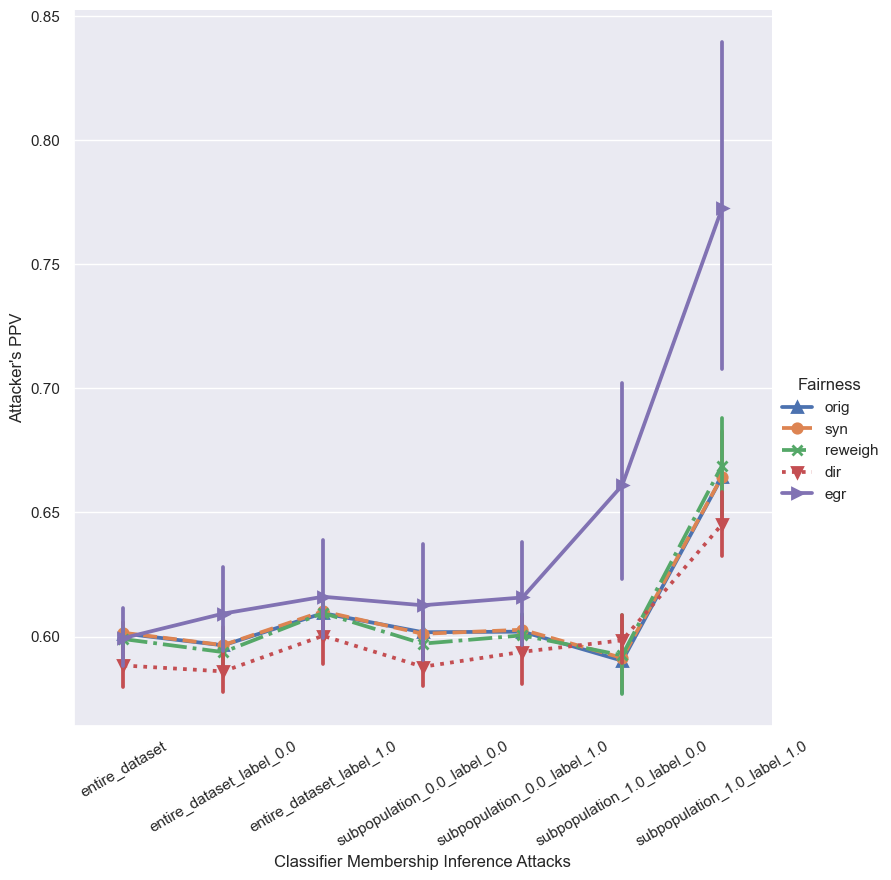

In [79]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
